# Tutorial
- Syndp 패키지를 이용해서 데이터를 합성하는 알고리즘에 대한 튜토리얼입니다.
- input 데이터가 어떻게 들어가는지, output은 어떻게 생겼는지 보여드리고,
- code 파일에 있는 알고리즘에 대한 설명으로 튜토리얼을 마무리 하도록 하겠습니다.



## Data expained
- 데이터는 data 폴더에 들어있음.
- 데이터는 MIMIC 데이터의 일부 시계열 데이터를 가져왔음.
```
data━┳━ processed*

```

- 데이터는 다변량 형태이나 단일 변량으로 processing 하여 syndp에서 사용할 수 있도록 만들어주겠습니다.

In [66]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

project_dir = Path().cwd().parent
data_dir = project_dir.joinpath('data')

# load data
death = pd.read_csv(data_dir.joinpath('processed/death_df.csv'))

death.head()

,subject_id,stay_id,hour,heart_rate,sbp,dbp,mbp,resp_rate,spo2
0,10001884,37510196,0,68.0,138.0,77.0,96.0,19.0,99.0
1,10001884,37510196,1,65.0,121.0,73.0,87.0,19.0,97.0
2,10001884,37510196,2,63.0,123.0,72.0,86.0,18.0,97.0
3,10001884,37510196,3,63.0,125.0,74.0,90.0,20.0,97.0
4,10001884,37510196,4,66.0,107.0,67.0,79.0,19.0,97.0


위에서 보이듯 tabular data 형태이며 hour로 시간에 대한 index가 나타나 있으며 hr, sbp, mbp 등 시계열 연속형 변수를 볼 수 있다.

본 tutorial에서는 단일 변량에 대해서 검증하는 방법을 숙지하는 것을 목표로 하겠음. 여기서는 HR, hour, ID 정보만 사용한다.

In [10]:
sample = death[['subject_id','hour','heart_rate']].copy()

데이터 형식을 환자를 row로, hour이 column이 되게끔 바꿔준다.

In [25]:
pivoted_sample = sample.pivot_table(index="subject_id", columns="hour", values='heart_rate').reset_index()
pivoted_sample.head()

hour,subject_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,10001884,68.0,65.0,63.0,63.0,66.0,66.0,65.0,66.0,66.0,...,71.0,74.0,74.0,72.0,74.0,77.0,87.0,75.0,NaN,74.0
1,10002155,NaN,NaN,NaN,NaN,114.0,117.5,137.5,129.5,117.0,...,126.0,129.0,109.0,102.0,120.0,110.0,97.0,98.0,93.0,75.0
2,10003400,122.0,129.0,130.0,130.0,129.0,120.0,119.0,121.0,138.0,...,125.0,135.0,141.0,141.0,141.0,149.0,149.0,148.0,144.0,147.0
3,10004401,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,...,70.0,70.0,70.0,70.0,70.0,71.0,70.0,70.0,70.0,70.0
4,10004720,NaN,85.0,82.0,70.0,86.0,80.0,83.0,73.0,72.0,...,88.0,76.0,74.0,85.0,101.0,108.0,106.0,94.0,106.0,NaN


각 데이터는 Null 값을 갖고 있기 때문에 이들에 대해서 linear interpolation을 적용하도록 한다.

In [45]:
pivoted_sample.loc[:,0:23] = pivoted_sample.loc[:,0:23].interpolate(axis=1, limit_direction='both')
pivoted_sample.head()

hour,subject_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,10001884,68.0,65.0,63.0,63.0,66.0,66.0,65.0,66.0,66.0,...,71.0,74.0,74.0,72.0,74.0,77.0,87.0,75.0,74.5,74.0
1,10002155,114.0,114.0,114.0,114.0,114.0,117.5,137.5,129.5,117.0,...,126.0,129.0,109.0,102.0,120.0,110.0,97.0,98.0,93.0,75.0
2,10003400,122.0,129.0,130.0,130.0,129.0,120.0,119.0,121.0,138.0,...,125.0,135.0,141.0,141.0,141.0,149.0,149.0,148.0,144.0,147.0
3,10004401,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,...,70.0,70.0,70.0,70.0,70.0,71.0,70.0,70.0,70.0,70.0
4,10004720,85.0,85.0,82.0,70.0,86.0,80.0,83.0,73.0,72.0,...,88.0,76.0,74.0,85.0,101.0,108.0,106.0,94.0,106.0,106.0


In [51]:
if pivoted_sample.isna().sum().sum() == 0 : print('Na인 값 없음 확인')

Na인 값 없음 확인


# syndp 활용
- syndp에 현재는 original timedp와 timedp algoritm이 있다.
- original timedp 알고리즘은 시계열 데이터의 전후를 boundary로 잡아서 noise를 주는 메커니즘이다.
- 본 튜토리얼에서는 original timedp 알고리즘을 활용해서 노이즈를 주는 실험을 해보도록 하겠다.

* Note
    - 반드시 시계열 데이터들의 time step이 일치해야 syndp 알고리즘이 돌아가는 것은 아니다.

In [57]:
# path append for syndp
import os, sys
os.sys.path.append(project_dir.absolute().as_posix())

from syndp.algorithm import original_timedp as odp # original time dp 알고리즘. 

- original time dp algorithm
    - odp의 timeseries_dp를 이용해야 함
    - 알고리즘의 input : 시계열 데이터, epsilon
    - 알고리즘의 output : 합성된 시계열 데이터

In [65]:
# 피벗 테이블의 timeseries sampel을 하나 사용해보도록 하겠다.
epsilon = 0.1

timeseries_sample = pivoted_sample.loc[0,0:]
syntheszied_sample = odp.timeseries_dp(timeseries_sample, epsilon)

[[-0.44874487]]


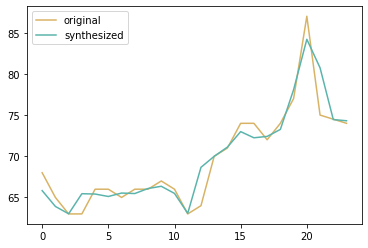

In [72]:
plt.plot(timeseries_sample,'#d8b365', label='original')
plt.plot(syntheszied_sample,'#5ab4ac', label='synthesized')
plt.legend()

원본과 비슷한 시계열 데이터 생성을 하는 것을 확인할 수 있다